In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import lux
import matplotlib.pyplot as plt
%matplotlib inline

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

np.set_printoptions(suppress=True) # do not print scientific notation

# Set some matplotlib style parameters
plt.style.use('seaborn')
plt.rcParams.update({'figure.facecolor': 'white',
                     'figure.edgecolor': 'white',
                     'axes.grid': True,
                     'figure.autolayout': True # tight_layout
                    })

# Set some pandas options
pd.set_option('display.max_columns', None, # show x columns (None shows all)
              # 'display.max_rows', None,  # show x rows (None shows all)
              'compute.use_numba', True)   # turn off for Lux

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
seed = 42
rng = np.random.default_rng(seed)

n = secure_bits = 1         # rows
m = corrected_key_bits = 10 # columns
N_vec = 10000               # nº of corrected key vectors

## Functions

### Detect power consumption of basic operations

In [3]:
# def get_product_power(mat, vec, op_powers):
#     '''
#     Returns: count[0] -> 0*0 power
#              count[1] -> 0*1 power
#              count[2] -> 1*0 power
#              count[3] -> 1*1 power
#     '''
#     n, m = mat.shape
#     count = np.zeros((4, n, m))
#     for i in range(n):
#         for j in range(m):
#             if not mat[i, j] and not vec[j]:
#                 count[0, i, j] = 1
#             if not mat[i, j] and vec[j]:
#                 count[1, i, j] = 1
#             if mat[i, j] and not vec[j]:
#                 count[2, i, j] = 1
#             if mat[i, j] and vec[j]:
#                 count[3, i, j] = 1
#     return np.asarray([(count[i] * power).ravel() for i, power in enumerate(op_powers)])

# Cooler version :)
def get_product_power(mat, vec, op_powers, noise_std=0.):
    '''Returns: array with the power of each product.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            count[i, j] = op_powers[2 * mat[i, j] + vec[j]] + rng.normal(scale=noise_std)
    return count.ravel()

In [4]:
# def get_sum_power(mat, vec, op_powers):
#     '''
#     Returns: count[0] -> 0+0 power
#              count[1] -> 0+1 power
#              count[2] -> 1+0 power
#              count[3] -> 1+1 power
#     '''
#     n, m = mat.shape
#     count = np.zeros((4, n, m))
#     for i in range(n):
#         result = 0
#         for j in range(m):
#             next_element = mat[i, j] * vec[j]
#             if not result and not next_element:
#                 count[0, i, j] = 1
#             if not result and next_element:
#                 count[1, i, j] = 1
#             if result and not next_element:
#                 count[2, i, j] = 1
#             if result and next_element:
#                 count[3, i, j] = 1
#             result = (result + next_element) % 2
#     return np.asarray([(count[i] * power).ravel() for i, power in enumerate(op_powers)])

# Cooler version :)
def get_sum_power(mat, vec, op_powers, noise_std=0.):
    '''Returns: array with the power of each sum.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = np.zeros((n, m))
    for i in range(n):
        result = 0
        for j in range(m):
            next_element = mat[i, j] * vec[j]
            count[i, j] = op_powers[2 * result + next_element] + rng.normal(scale=noise_std)
            result = (result + next_element) % 2
    return count.ravel()

In [5]:
# # TEST
# mat = np.asarray([[0, 1, 1, 0, 1],
#                   [1, 0, 1, 1, 1],
#                   [1, 1, 1, 1, 1],
#                   [0, 0, 0, 0, 0]])
# # vec = np.asarray([0, 0, 0, 0, 0])
# # vec = np.asarray([1, 1, 1, 1, 1])
# vec = np.asarray([1, 1, 1, 0, 0])
# n, m = mat.shape

# print(mat @ vec % 2, '\n')
# count = get_product_power(mat, vec, [.1, .2, .3, .4], 0.01)
# for i in range(n): print(np.around(count[i*m:(i+1)*m], 3))
# print()
# count = get_sum_power(mat, vec, [1.1, 1.2, 1.3, 1.4], 0.01)
# for i in range(n): print(np.around(count[i*m:(i+1)*m], 3))

### Class

In [6]:
# Detect if there are more 1s than 0s
def More_1_than_0(mat, vec):
    return np.sum(mat @ vec % 2) > secure_bits / 2

### Other

In [7]:
# Check if output vectors from sample are unique
def Check_uniqueness(mat, vec):
    res = []
    for i in range(len(vec)):
        res.append(mat @ vec[i] % 2)
    unique = np.unique(res, axis=0, return_counts=True)
    return unique[1].shape[0] == np.shape(vec)[0], unique[1].shape[0]

## Generate data

In [8]:
mat = rng.integers(2, size=(secure_bits,corrected_key_bits), dtype=np.int8)

mat.shape, mat

((1, 10), array([[1, 0, 1, 0, 1, 1, 0, 1, 1, 1]], dtype=int8))

In [9]:
vec = [rng.integers(2, size=corrected_key_bits, dtype=np.int8) for _ in range(N_vec)]

np.shape(vec), vec[0]

((10000, 10), array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int8))

In [10]:
print('Are solutions from this sample unique? %s ---> %i unique sols out of %i' % (*Check_uniqueness(mat, vec), N_vec))

Are solutions from this sample unique? False ---> 2 unique sols out of 10000


Assumptions on power consumption (based on https://ieeexplore.ieee.org/document/6644863):
- NOT:
    - 0 - 6.73 pA ~ 7 pA
    - 1 - 7.45 pA ~ 7 pA
- 2-input NOR:
    - 00 - 13.50 pA
    - 01 - 12.80 pA
    - 10 - &nbsp; 7.93 pA
    - 11 - &nbsp; 5.93 pA
- 2-input NAND:
    - 00 - &nbsp; 5.79 pA
    - 01 - &nbsp; 7.00 pA
    - 10 - 11.77 pA
    - 11 - 14.91 pA

Writing our operations in the gates above:
- A\*B &nbsp;= AND(A, B)
= NOT(NAND(A, B))

- A+B = XOR(A, B)
= NOT(A<=>B)
= NOT(AND(A->B, B->A))
= NAND(A->B, B->A)
= NAND(OR(NOT(A), B), OR(NOT(B), A)) =  
&nbsp; &nbsp; &nbsp; &nbsp; = NAND(NOT(NOR(NOT(A), B)), NOT(NOR(NOT(B), A)))

Thus:
- 0\*0: &nbsp; &nbsp; 5.79 + 7 = 12.79 pA
- 0\*1: &nbsp; &nbsp; 7.00 + 7 = 14.00 pA
- 1\*0: &nbsp; 11.77 + 7 = 18.77 pA
- 1\*1: &nbsp; 14.91 + 7 = 21.91 pA


- 0+0: &nbsp; (7 + 7.93 + 7) + (7 + 7.93 + 7) + 14.91 = 58.77 pA
- 0+1: &nbsp; (7 + 5.93 + 7) + (7 + 13.5 + 7) + 11.77 = 59.20 pA
- 1+0: &nbsp; (7 + 13.5 + 7) + (7 + 5.93 + 7) + 7 &nbsp; &nbsp; &nbsp; &nbsp;= 54.43 pA
- 1+1: &nbsp; (7 + 12.8 + 7) + (7 + 12.8 + 7) + 14.91 = 68.51 pA

In [10]:
# Define power consumption for each operation & noise level
power_products = np.asarray([12.79,  14., 18.77, 21.91]) # 0*0, 0*1, 1*0, 1*1
power_sums     = np.asarray([58.77, 59.2, 54.43, 68.51]) # 0+0, 0+1, 1+0, 1+1
noise_std = 0.05 + 0.5 # article measurement precision + hacker device noise

In [12]:
i = 0
print('Products:', np.around(get_product_power(mat, vec[i], power_products, noise_std), 4))
print('Sums:    ', np.around(get_sum_power(mat, vec[i], power_sums, noise_std), 4))

Products: [18.9518 12.1148 19.7449 12.23   18.9559 18.6288 13.7632 19.1904 22.0445
 19.0523]
Sums:     [58.3214 58.6743 58.3468 58.6605 58.7047 59.7844 58.6273 57.6009 59.9673
 54.6771]


In [13]:
print("#1 > #0?")
print("--------")
for i in range(10):
    print(More_1_than_0(mat, vec[i]), '\t', mat @ vec[i] % 2)

#1 > #0?
--------
True 	 [1]
True 	 [1]
False 	 [0]
False 	 [0]
True 	 [1]
True 	 [1]
False 	 [0]
True 	 [1]
False 	 [0]
False 	 [0]


In [11]:
# Warning: data is not time-ordered, i.e. row-by-row power
data = np.asarray([[*get_product_power(mat, vec[i], power_products, noise_std),
                    *get_sum_power(mat, vec[i], power_sums, noise_std),
                    More_1_than_0(mat, vec[i])] for i in range(N_vec)])
data.shape

(10000, 21)

In [12]:
# Create column labels
row_bits = [str(i // m)+','+str(i % m) for i in range(n * m)]
columns = row_bits + ['+'+row_bits[i] for i in range(n * m)] + ['More_1_than_0']

# Create dataframe for plotting raw data
df_raw = pd.DataFrame(data, columns=columns).astype({'More_1_than_0': bool})
df_raw.drop_duplicates(inplace=True, ignore_index=True)
np.around(df_raw, 3)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

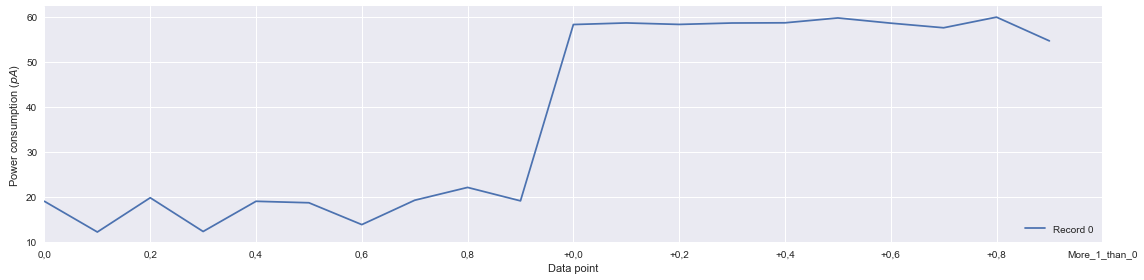

In [13]:
# Plot power consumption through time
    # (need to separate operations into gates to be more realistic)
y = df_raw.iloc[0][:-1]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*0.95, y.max()*1.05)
plt.xticks(np.linspace(0, len(y), len(df_raw.columns[::2])), df_raw.columns[::2])
# plt.yticks(np.arange(10, 61, 10))

# Set labels
plt.legend(loc='lower right') # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
# plt.title('Power consumption', fontsize=14)

# plt.savefig('Results/plot_y.png', dpi=200)
plt.show()

In [14]:
# Create centered dataframe (for each operation)
data[:, :n*m]      -= data[:, :n*m].mean(axis=1, keepdims=True)      # products
data[:, n*m:2*n*m] -= data[:, n*m:2*n*m].mean(axis=1, keepdims=True) # sums

df = pd.DataFrame(data, columns=columns).astype({'More_1_than_0': bool})
df.drop_duplicates(inplace=True, ignore_index=True)
np.around(df, 3)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

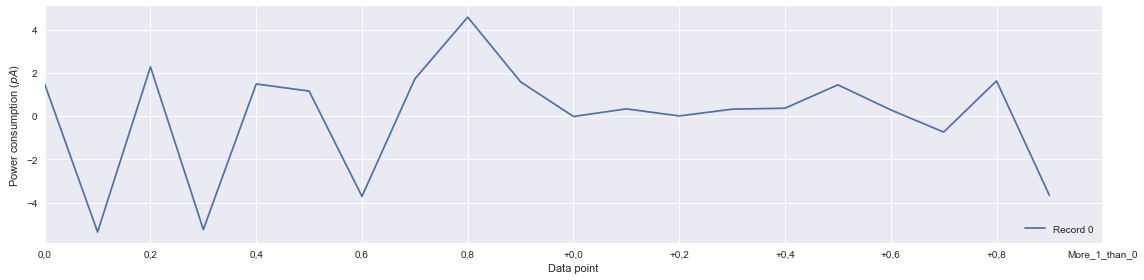

In [15]:
# Plot centered data: power consumption through time
    # (need to separate operations into gates to be more realistic)
y = df.iloc[0][:-1]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*0.95, y.max()*1.05)
plt.xticks(np.linspace(0, len(y), len(df.columns[::2])), df.columns[::2])
# plt.yticks(np.arange(-4, 4, 2))

# Set labels
plt.legend(loc='lower right') # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
# plt.title('Power consumption', fontsize=14)

# plt.savefig('Results/plot_y.png', dpi=200)
plt.show()

In [16]:
# # Drop columns with equal values (worthless with noise)
# def duplicate_columns(df):
#     groups = df.columns.to_series().groupby(df.dtypes).groups
#     dups = []
#     for t, v in groups.items():
#         dcols = df[v].to_dict(orient='list')
#         vs = list(dcols.values())
#         ks = list(dcols.keys())
#         for i in range(len(vs)):
#             for j in range(i+1, len(vs)):
#                 if vs[i] == vs[j]: 
#                     dups.append(ks[i])
#                     break
#     if dups: print('Duplicate columns:', *dups)
#     return dups

# df.drop(duplicate_columns(df), axis=1, inplace=True)
# np.around(df, 3)

In [17]:
# Check some trends in data (turn off numba engine first)
pd.set_option('compute.use_numba', False)
df2 = df.copy()
df2.intent = ['More_1_than_0']
display(df2)
pd.set_option('compute.use_numba', True)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [486]:
# Generate pandas profiling report
profile = ProfileReport(df, title=f'More_1s_or_0s Noisy_Power_per_Op noise_std={noise_std} Dataset Report', explorative=True)
# profile.to_widgets()
profile.to_file(f'Docs/More_1s_or_0s_-_Noisy_Power_per_Op_noisestd={noise_std}_report.html')

Summarize dataset:   0%|          | 0/161 [00:00<?, ?it/s]

C:\Users\V082335\Anaconda3\lib\site-packages\pandas\core\series.py:1441: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Split data

In [18]:
# Split data into training & test set
X = np.asarray(df.drop('More_1_than_0', axis=1))
y = np.asarray(df['More_1_than_0'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # used before cross-val

## Classifiers

### Logs

###### Noise std. dev. <= 0.1
Models able to to predict with ~100% accuracy:
- Logistic regression
- All SVM
- Decision tree

Models which comparatively suck:
- Gaussian Naïve Bayes

###### Noise std. dev. = 1
Models able to to predict with 92% < accuracy < 97%:
- Logistic regression
- All SVM
- Decision tree

Models which comparatively suck:
- Gaussian Naïve Bayes

###### Noise std. dev. = 2
Models able to to predict with 79% < accuracy < 86%:
- Logistic regression
- All SVM
- Decision tree

Models which comparatively suck:
- Gaussian Naïve Bayes

###### Noise std. dev. = 10
Best accuracy: ~62%

### Functions to train & test models

In [20]:
# Train model with stratified k-fold cross-validation & get statistics
def Train_stratCV(model, X, y, n_splits=5, seed=seed):
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=seed)
    lst_acc = []
    lst_y_pred = [] # not used yet

    # Train & test each fold
    for train_idx, test_idx in skf.split(X, y):
        x_train_fold, x_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        model.fit(x_train_fold, y_train_fold)
        lst_acc.append(model.score(x_test_fold, y_test_fold))
        lst_y_pred.append(model.predict(x_test_fold))

    print(f'\nList of accuracies: {lst_acc}')
    print(f'Min/max accuracy:   {min(lst_acc):.2%} <---> {max(lst_acc):.2%}')
    print(f'Mean accuracy:      {np.mean(lst_acc):.2%} +- {np.std(lst_acc):.3%}')
    
    # add more stats
    
    return lst_acc, lst_y_pred

# accuracy_score(y_test, y_pred) # how often is the classifier correct?
# confusion_matrix(y_test, y_pred, normalize='pred') # precision
# confusion_matrix(y_test, y_pred, normalize='true') # recall
# classification_report(y_test, y_pred, output_dict=True)

In [21]:
# Test different parameters
def test_eta0(model, low, up, Xs, ys, seed):
    for j, (X, y) in enumerate(zip(Xs, ys)):
        print(f'\n---> X{j}, y{j}')
        for i in range(low, up):
            model.eta0 = 10.**i
            model.verbose = 0
            acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
            print(f'eta0 = {model.eta0:.0e}')

def test_coef0(model, low, up, Xs, ys, seed):
    for j, (X, y) in enumerate(zip(Xs, ys)):
        print(f'\n---> X{j}, y{j}')
        for i in np.arange(low, up, 1):
            model.coef0 = i
            model.verbose = 0
            acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
            print(f'coef0 = {model.coef0}')

def test_trees(model, Xs, ys, seed, max_depth=[None], max_features=[None], max_leaf_nodes=[None], min_impurity_decrease=[0.]):
    for j, (X, y) in enumerate(zip(Xs, ys)):
        print(f'\n---> X{j}, y{j}')
        for md in max_depth:
            model.max_depth = md
            for mf in max_features:
                model.max_features = mf
                for mln in max_leaf_nodes:
                    model.max_leaf_nodes = mln
                    for mid in min_impurity_decrease:
                        model.min_impurity_decrease = mid
                        acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
                        print(f'{md}, {mf}, {mln}, {mid:.0e}')

### Logistic regression

In [23]:
model = SGDClassifier(loss='log', learning_rate='adaptive', eta0=1e-3, max_iter=1e5, tol=1e-5, n_jobs=-1, random_state=seed,
                      verbose=-1)
# test_eta0(model, -7, 8)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

Convergence after 98 epochs took 0.16 seconds
Convergence after 91 epochs took 0.17 seconds
Convergence after 85 epochs took 0.19 seconds
Convergence after 89 epochs took 0.18 seconds
Convergence after 107 epochs took 0.25 seconds

List of accuracies: [0.972, 0.9725, 0.9775, 0.9665, 0.9665]
Min/max accuracy:   96.65% <---> 97.75%
Mean accuracy:      97.10% +- 0.415%


In [164]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### SVM

#### Linear kernel

In [32]:
model = SVC(kernel='linear', probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.782, 0.798, 0.806, 0.7905, 0.79]
Min/max accuracy:   78.20% <---> 80.60%
Mean accuracy:      79.33% +- 0.812%


In [646]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [30]:
model = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=1e-5, tol=1e-5, n_jobs=-1, random_state=seed, verbose=-1)
# test_eta0(model, -7, 8)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

Convergence after 59 epochs took 0.03 seconds
Convergence after 55 epochs took 0.04 seconds
Convergence after 49 epochs took 0.03 seconds
Convergence after 66 epochs took 0.04 seconds
Convergence after 60 epochs took 0.03 seconds

List of accuracies: [0.7845, 0.8005, 0.806, 0.7915, 0.79]
Min/max accuracy:   78.45% <---> 80.60%
Mean accuracy:      79.45% +- 0.771%


In [186]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

In [31]:
model = LinearSVC(loss='squared_hinge', dual=False, tol=1e-5, random_state=seed, verbose=1)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
List of accuracies: [0.78, 0.8, 0.8095, 0.79, 0.7855]
Min/max accuracy:   78.00% <---> 80.95%
Mean accuracy:      79.30% +- 1.054%


In [188]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Gaussian kernel

In [34]:
model = SVC(kernel='rbf', gamma='scale', tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.835, 0.837, 0.829, 0.827, 0.842]
Min/max accuracy:   82.70% <---> 84.20%
Mean accuracy:      83.40% +- 0.544%


In [33]:
model = SVC(kernel='rbf', gamma='auto', tol=1e-5, probability=False, random_state=seed, verbose=True)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.7985, 0.8115, 0.828, 0.8, 0.8075]
Min/max accuracy:   79.85% <---> 82.80%
Mean accuracy:      80.91% +- 1.059%


In [189]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Polynomial kernel

In [41]:
model = SVC(kernel='poly', degree=3, coef0=1., tol=1e-5, probability=False, random_state=seed, verbose=True)
# test_coef0(model, -1, 2)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.8315, 0.844, 0.8335, 0.824, 0.8395]
Min/max accuracy:   82.40% <---> 84.40%
Mean accuracy:      83.45% +- 0.686%


In [43]:
model = SVC(kernel='poly', degree=4, coef0=1., tol=1e-5, probability=False, random_state=seed, verbose=True)
# test_coef0(model, -1, 2)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.8315, 0.845, 0.8335, 0.824, 0.834]
Min/max accuracy:   82.40% <---> 84.50%
Mean accuracy:      83.36% +- 0.673%


In [657]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Sigmoid kernel

In [106]:
model = SVC(kernel='sigmoid', gamma='scale', coef0=-1., tol=1e-5, probability=False, random_state=seed, verbose=True)
# test_coef0(model, -1, 2)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.802, 0.8135, 0.8125, 0.806, 0.8075]
Min/max accuracy:   80.20% <---> 81.35%
Mean accuracy:      80.83% +- 0.425%


In [107]:
model = SVC(kernel='sigmoid', gamma='auto', coef0=-1., tol=1e-5, probability=False, random_state=seed, verbose=True)
# test_coef0(model, -1, 2)
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
List of accuracies: [0.532, 0.545, 0.5385, 0.528, 0.539]
Min/max accuracy:   52.80% <---> 54.50%
Mean accuracy:      53.65% +- 0.592%


In [658]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Naïve Bayes

#### Gaussian NB

In [108]:
model = GaussianNB()
# model.fit(X_train, y_train) # used before cross-val
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)


List of accuracies: [0.7115, 0.738, 0.7535, 0.72, 0.733]
Min/max accuracy:   71.15% <---> 75.35%
Mean accuracy:      73.12% +- 1.456%


In [136]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Multinomial NB

In [135]:
model = MultinomialNB() # does not work with negative values
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

In [43]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

#### Categorical NB

In [253]:
model = CategoricalNB() # does not work with negative values
# model.fit(X_train, y_train) # used before cross-val
# acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)

In [2]:
# # Get prediction statistics (used before cross-val)
# y_pred = model.predict(X_test)
# print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
# print('\nReport: \n', classification_report(y_test, y_pred, digits=3))

# print(f'Mean accuracy on test set: {model.score(X_test, y_test):.2%}')

# y_prob = model.predict_proba(X_test)
# print(f'Mean certainty (even if wrong): {np.mean(np.max(y_prob, axis=1)):.2%}')

### Decision tree

In [22]:
model = DecisionTreeClassifier(max_depth=None,
                               max_features=16,
                               max_leaf_nodes=None,
                               min_impurity_decrease=9e-4,
                               random_state=seed)
# test_trees(model,
#            # max_depth=range(1, 10),
#            # max_depth=[10],
#            # max_features=range(3, 21),
#            # max_features=[16],
#            # max_leaf_nodes=range(10, 22),
#            # max_leaf_nodes=[20],
#            # min_impurity_decrease=10.**np.arange(-9, 0),
#            # min_impurity_decrease=1e-3*np.asarray([0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5]),
#            min_impurity_decrease=[9e-4],
#           )
acc_strat, y_pred = Train_stratCV(model, X, y, 5, seed)
# cross_val_score(model, X, y, cv=5, n_jobs=-1, verbose=1)

model.get_depth(), model.get_n_leaves()


List of accuracies: [0.9835, 0.985, 0.9865, 0.993, 0.988]
Min/max accuracy:   98.35% <---> 99.30%
Mean accuracy:      98.72% +- 0.326%


(8, 11)

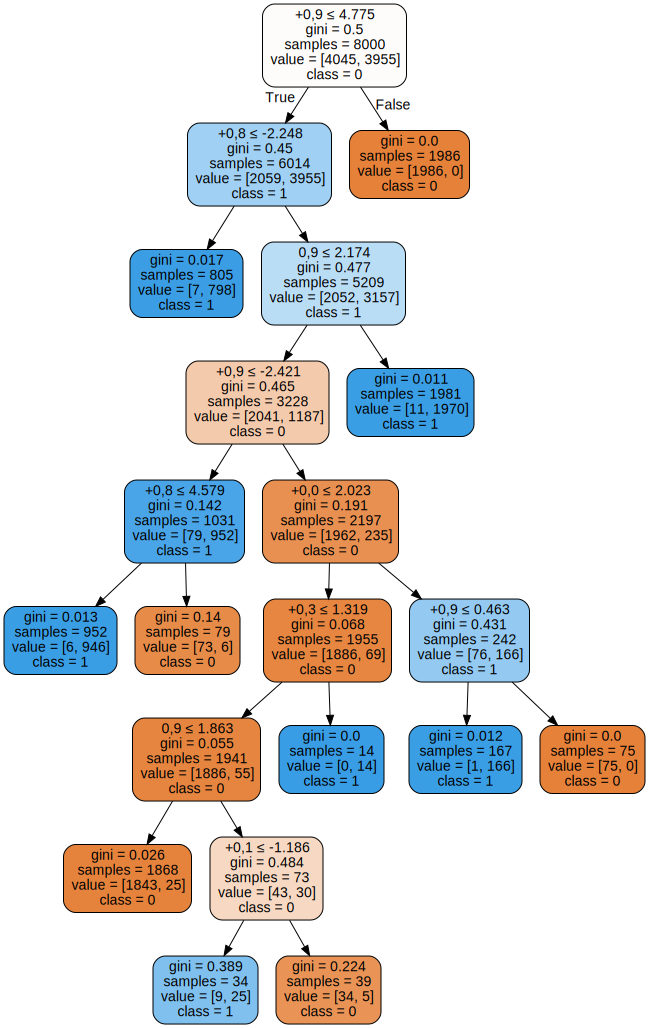

In [25]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(model, feature_names=df.columns[:-1], class_names=['0','1'],
                           filled=True, rounded=True, special_characters=True)
# Draw tree
graph = graphviz.Source(dot_data)
graph.render(f'Docs/DTree_noisy_power_per_op_noisestd={noise_std}', format='png', cleanup=True)
graph